In [23]:
import json
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay
from torchvision import datasets, transforms, models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
# Define dataset path
dataset_dir = "processed_dataset_split"

# Custom function to assign severity labels
def get_corrosion_label(image_path):
    if "1hr" in image_path or "1day" in image_path:
        return 0  # Low Corrosion
    elif "7days" in image_path:
        return 1  # Moderate Corrosion
    elif "14days" in image_path or "21days" in image_path:
        return 2  # Severe Corrosion
    else:
        return None

# Custom Dataset Loader with Correct Labels
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)
        new_samples = []
        root_abs = os.path.abspath(root)  # Get absolute path of dataset root

        for img_path, _ in self.samples:
            full_path = os.path.join(root_abs, os.path.relpath(img_path, root))  # Ensure correct relative path
            label = get_corrosion_label(full_path)

            if label is not None:
                new_samples.append((full_path, label))

        self.samples = new_samples

In [25]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (needed for ResNet)
    transforms.Resize((224, 224)),  # Ensure uniform input size
    transforms.ToTensor(),  # Convert PIL image to tensor first
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize only after ToTensor()
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.3, hue=0.1),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.2)),
])

from torch.utils.data import DataLoader

# Define dataset paths correctly
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Load datasets with corrected paths
train_dataset = CustomImageFolder(train_dir, transform=transform)
val_dataset = CustomImageFolder(val_dir, transform=transform)
test_dataset = CustomImageFolder(test_dir, transform=transform)

In [26]:
from collections import Counter
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

# Get class distribution
train_labels = [label for _, label in train_dataset.samples]
class_counts = Counter(train_labels)  # FIX: Define class_counts correctly
print("Training Data Distribution:", class_counts)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.array(list(class_counts.keys())), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss in training
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)


Training Data Distribution: Counter({0: 45, 2: 27, 1: 17})


In [27]:
# Define batch size
batch_size = 32

# Create DataLoaders

from torch.utils.data import WeightedRandomSampler

# Compute sample weights
sample_weights = [1.0 / class_counts[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=False)


# Use oversampling in `train_loader`
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset summary
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 89
Validation samples: 12
Test samples: 16


In [28]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [29]:
# Training Function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, model_name, epochs):
    best_loss = float("inf")
    patience_counter = 0  # For early stopping
    history = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Apply Mixup
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.4)
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(train_loader)
        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)

        print(f"{model_name} - Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%")
        scheduler.step(train_loss)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()


        val_acc = 100.0 * correct / total
        val_loss /= len(val_loader)
        print(f"Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > 15:
            print("Early stopping triggered.")
            break

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history, f, indent=4)

In [30]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

# Load EfficientNet-B0 with pretrained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# ✅ Replace the classifier layer (EfficientNet uses `.classifier`)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 3)  # 3 corrosion classes

# Move model to device
model = model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Train the model
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, "model/efficientnet_b0_baseline", epochs=100)

model/efficientnet_b0_baseline - Epoch 1: Loss=1.0926, Train Acc=37.08%
Validation - Loss: 1.0357, Acc: 25.00%
model/efficientnet_b0_baseline - Epoch 2: Loss=0.9609, Train Acc=55.06%
Validation - Loss: 1.0038, Acc: 41.67%
model/efficientnet_b0_baseline - Epoch 3: Loss=0.9409, Train Acc=44.94%
Validation - Loss: 1.0381, Acc: 25.00%
model/efficientnet_b0_baseline - Epoch 4: Loss=0.9090, Train Acc=38.20%
Validation - Loss: 1.0182, Acc: 58.33%
model/efficientnet_b0_baseline - Epoch 5: Loss=0.9062, Train Acc=52.81%
Validation - Loss: 1.0331, Acc: 41.67%
model/efficientnet_b0_baseline - Epoch 6: Loss=0.9120, Train Acc=38.20%
Validation - Loss: 1.0431, Acc: 41.67%
model/efficientnet_b0_baseline - Epoch 7: Loss=0.8915, Train Acc=55.06%
Validation - Loss: 1.0264, Acc: 41.67%
model/efficientnet_b0_baseline - Epoch 8: Loss=0.9036, Train Acc=46.07%
Validation - Loss: 1.0177, Acc: 50.00%
model/efficientnet_b0_baseline - Epoch 9: Loss=0.8643, Train Acc=44.94%
Validation - Loss: 1.0038, Acc: 50.00%
m

In [38]:
# Load EfficientNet with pretrained weights
fine_tuned_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# ✅ Unfreeze later layers (last 3 blocks, for example)
for param in fine_tuned_model.features[-3:].parameters():
    param.requires_grad = True

# ✅ Make BatchNorm trainable
for m in fine_tuned_model.modules():
    if isinstance(m, nn.BatchNorm2d):
        for p in m.parameters():
            p.requires_grad = True

# Replace classifier with dropout + FC
in_features = fine_tuned_model.classifier[1].in_features
fine_tuned_model.classifier[1] = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, 3)
)

fine_tuned_model = fine_tuned_model.to(device)

optimizer_finetuned = optim.Adam(
    filter(lambda p: p.requires_grad, fine_tuned_model.parameters()),
    lr=0.0001
)

scheduler_finetuned = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_finetuned, mode='min', factor=0.5, patience=5
)

train_model(fine_tuned_model, criterion, optimizer_finetuned, scheduler_finetuned, train_loader, val_loader, "model/efficientnet_b0_finetuned", epochs=100)

model/efficientnet_b0_finetuned - Epoch 1: Loss=1.1002, Train Acc=31.46%
Validation - Loss: 1.1341, Acc: 25.00%
model/efficientnet_b0_finetuned - Epoch 2: Loss=1.0058, Train Acc=46.07%
Validation - Loss: 1.1839, Acc: 33.33%
model/efficientnet_b0_finetuned - Epoch 3: Loss=1.0422, Train Acc=43.82%
Validation - Loss: 1.0877, Acc: 41.67%
model/efficientnet_b0_finetuned - Epoch 4: Loss=0.9887, Train Acc=50.56%
Validation - Loss: 1.1496, Acc: 25.00%
model/efficientnet_b0_finetuned - Epoch 5: Loss=0.9807, Train Acc=50.56%
Validation - Loss: 1.0760, Acc: 41.67%
model/efficientnet_b0_finetuned - Epoch 6: Loss=0.9538, Train Acc=60.67%
Validation - Loss: 1.0898, Acc: 25.00%
model/efficientnet_b0_finetuned - Epoch 7: Loss=0.9185, Train Acc=50.56%
Validation - Loss: 1.0486, Acc: 33.33%
model/efficientnet_b0_finetuned - Epoch 8: Loss=0.8993, Train Acc=48.31%
Validation - Loss: 1.0359, Acc: 33.33%
model/efficientnet_b0_finetuned - Epoch 9: Loss=0.8721, Train Acc=58.43%
Validation - Loss: 1.0712, Acc:


Model Performance on Test Set:
Accuracy: 93.75%
Precision: 94.38%
Recall: 93.75%
F1-Score: 93.29%


<Figure size 600x500 with 0 Axes>

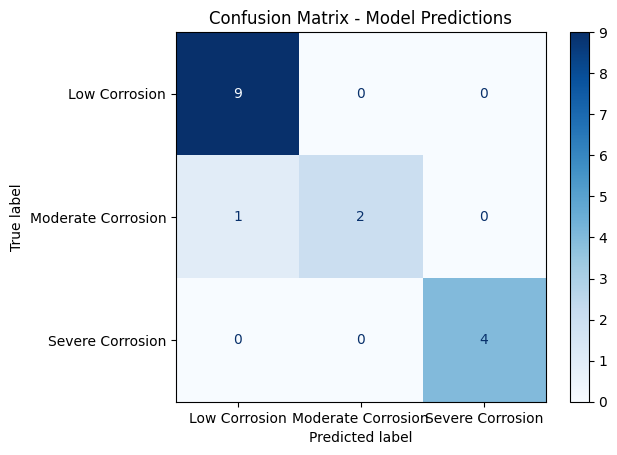

93.75

In [44]:
# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute classification metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = ["Low Corrosion", "Moderate Corrosion", "Severe Corrosion"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - Model Predictions")
    plt.show()

    return accuracy

# Run evaluation after training
evaluate_model(fine_tuned_model, test_loader)

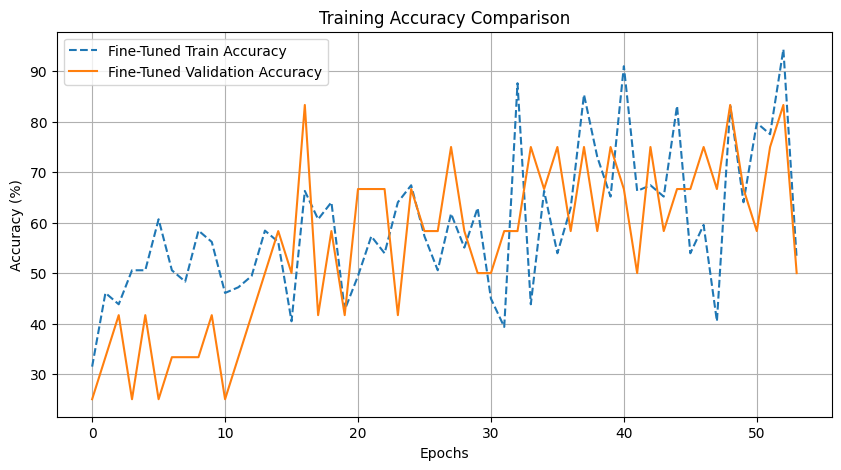

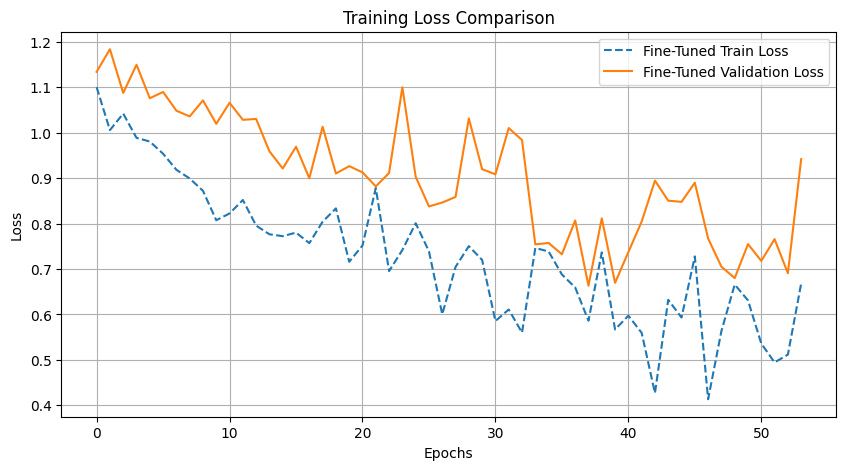

In [45]:
def plot_training_history(finetuned_file):
    import json
    import matplotlib.pyplot as plt

    with open(finetuned_file, "r") as f:
        finetuned_history = json.load(f)

    # Plot Training Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(finetuned_history["train_acc"], label="Fine-Tuned Train Accuracy", linestyle='dashed')
    plt.plot(finetuned_history["val_acc"], label="Fine-Tuned Validation Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Comparison")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(finetuned_history["train_loss"], label="Fine-Tuned Train Loss", linestyle='dashed')
    plt.plot(finetuned_history["val_loss"], label="Fine-Tuned Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.grid()
    plt.show()

# Call function to plot history after training
plot_training_history("model/efficientnet_b0_finetuned_history.json")